# DDPM

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [ ]:
set_seed(1103, False)

In [ ]:
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

## Load the dataset

In [ ]:
fm_x, fm_y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)

In [ ]:
xmean = tensor(0.28)
xstd = tensor(0.35)

@inplace
def transformi(b):
    b["image"] = [TF.resize(TF.to_tensor(i), (32,32), antialias=False) for i in b["image"]]
dst = ds.with_transform(transformi)

bs = 64
dls = DataLoaders.from_dd(dst, bs)
xb, yb = next(iter(dls.train))

In [ ]:
xb.shape

torch.Size([64, 1, 32, 32])

## Create model

In [ ]:
from diffusers import UNet2DModel

## Training - easy with a callback!

In [ ]:
n_steps = 1000
beta_min, beta_max = 10 ** (-4), 0.02
betas = torch.linspace(beta_min, beta_max, n_steps)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, 0)
sigmas = betas.sqrt()

In [ ]:
def add_noise(x, alphas_bar, n_steps):
    device = x.device
    bs = x.shape[0]

    t = torch.randint(0, n_steps, (bs,), dtype=torch.int64)
    alpha_bar_t = alphas_bar[t][:, None, None, None].to(device)
    
    original_part = alpha_bar_t.sqrt() * x
    epsilon = torch.randn(x.shape, device=device)
    noise_part = (1 - alpha_bar_t).sqrt() * epsilon

    xt = original_part + noise_part
    return (xt, t.to(device)), epsilon

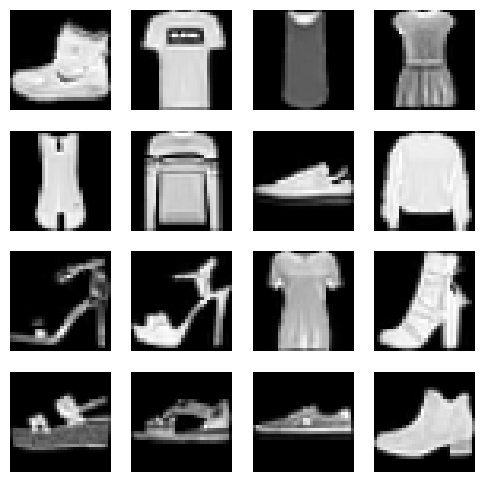

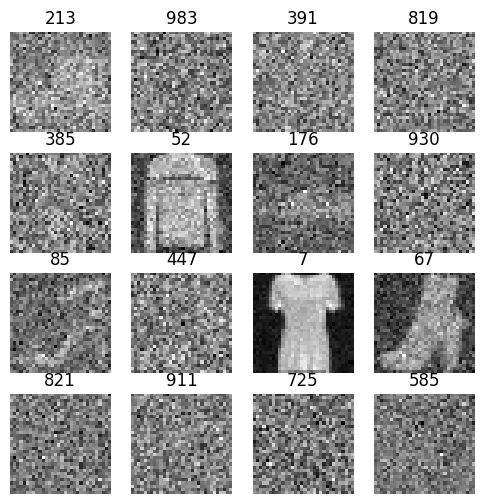

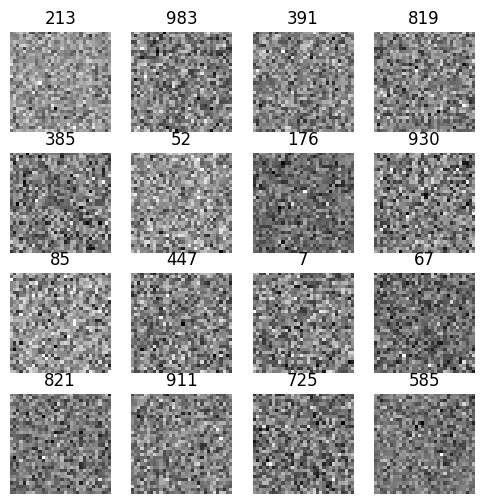

In [ ]:
set_seed(1103, False)
((xt, t), noise) = add_noise(xb[:16], alphas_bar, n_steps)
titles = list(map(lambda x: str(x.item()), t))
show_images(xb[:16], imsize=1.5)
show_images(xt, imsize=1.5, titles=titles)
show_images(noise, imsize=1.5, titles=titles)

In [ ]:
def sample(model, sz, n_steps, alphas, alphas_bar, sigmas):
        device = next(model.parameters()).device
        with torch.no_grad():
            x = torch.randn(sz, device=device)
            bs = x.shape[0]
            process = []
    
            for t in reversed(range(n_steps)):
                t_batch = torch.full((bs,), t, dtype=torch.int64)
    
                # Repametrized equation (4)
                noise_pred = model(x, t_batch.to(device)).sample
                alpha_bar_t = alphas_bar[t]
                x0_est = (x - (1 - alpha_bar_t).sqrt() * noise_pred) * (1 / alpha_bar_t.sqrt())
                x0_est = x0_est.clamp(0, 1)
    
                # Equations (7) and (8)
                alpha_bar_t_minus_1 = torch.tensor(1) if t == 0 else alphas_bar[t - 1]
                x0_coef = alpha_bar_t_minus_1.sqrt() * betas[t] / (1 - alpha_bar_t)
                xt_coef = alphas[t].sqrt() * (1 - alpha_bar_t_minus_1) / (1 - alpha_bar_t)
                noise_sample = torch.zeros(x.shape, device=device) if t == 0 else torch.randn(x.shape, device=device)
                x = x0_coef * x0_est + x * xt_coef + sigmas[t] * noise_sample
    
                process.append(to_cpu(x))
    
        return process

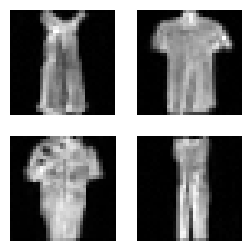

In [ ]:
set_seed(1103, False)
show_images(
    sample(torch.load("models/15_ddpm.pkl"), (4, 1, 32, 32), n_steps, alphas, alphas_bar, sigmas)[-1],
    imsize=1.5
)

In [ ]:
# Change model to accept only 1 arg (now assume UNet)
def sample(model, sz, n_steps, alphas, alphas_bar, sigmas):
        device = next(model.parameters()).device
        with torch.no_grad():
            x = torch.randn(sz, device=device)
            bs = x.shape[0]
            process = []
    
            for t in reversed(range(n_steps)):
                t_batch = torch.full((bs,), t, dtype=torch.int64)
    
                # Repametrized equation (4)
                noise_pred = model((x, t_batch.to(device)))
                alpha_bar_t = alphas_bar[t]
                x0_est = (x - (1 - alpha_bar_t).sqrt() * noise_pred) * (1 / alpha_bar_t.sqrt())
                x0_est = x0_est.clamp(0, 1)
    
                # Equations (7) and (8)
                alpha_bar_t_minus_1 = torch.tensor(1) if t == 0 else alphas_bar[t - 1]
                x0_coef = alpha_bar_t_minus_1.sqrt() * betas[t] / (1 - alpha_bar_t)
                xt_coef = alphas[t].sqrt() * (1 - alpha_bar_t_minus_1) / (1 - alpha_bar_t)
                noise_sample = torch.zeros(x.shape, device=device) if t == 0 else torch.randn(x.shape, device=device)
                x = x0_coef * x0_est + x * xt_coef + sigmas[t] * noise_sample
    
                process.append(to_cpu(x))
    
        return process

In [ ]:
class DDPMCB(Callback):
    order = DeviceCB.order + 1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        fc.store_attr()
        self.betas = torch.linspace(beta_min, beta_max, n_steps)
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, 0)
        self.sigmas = self.betas.sqrt()  # The simpler of the 2

    def before_batch(self, learn):
        learn.batch = add_noise(learn.batch[0], self.alphas_bar, self.n_steps)
    def sample(self, model, sz):
        return sample(model, sz, self.n_steps, self.alphas, self.alphas_bar, self.sigmas)

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x):
        return super().forward(*x).sample

In [ ]:
ddpm = DDPMCB(1000, 10**(-4), 0.02)

In [ ]:
doc = UNet2DModel.__doc__
doc = doc[doc.find("norm_num_groups"):]
doc = doc.split("\n", 1)[0]
print(doc)

norm_num_groups (`int`, *optional*, defaults to `32`): The number of groups for normalization.


In [ ]:
xb.shape

torch.Size([64, 1, 32, 32])

In [ ]:
set_seed(1103, False)
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)
cbs = [ddpm, SingleBatchCB()]
learn = TrainLearner(model, dls, F.mse_loss, cbs=cbs)
learn.fit(train=False)

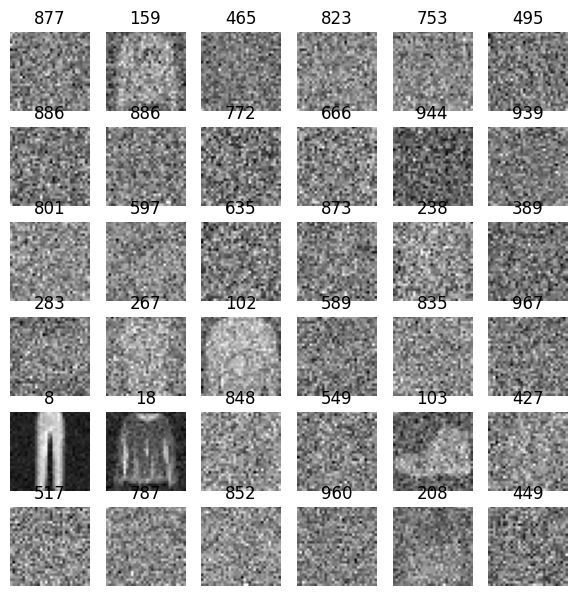

In [ ]:
inp = learn.batch[0][0][:36]
t = learn.batch[0][1][:36]
titles = list(map(lambda x: str(x.item()), t))
show_images(inp, imsize=1.2, titles=titles)

In [ ]:
learn.model.down_blocks[0]

DownBlock2D(
  (resnets): ModuleList(
    (0-1): 2 x ResnetBlock2D(
      (norm1): GroupNorm(8, 16, eps=1e-05, affine=True)
      (conv1): LoRACompatibleConv(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_emb_proj): LoRACompatibleLinear(in_features=64, out_features=16, bias=True)
      (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
      (conv2): LoRACompatibleConv(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (nonlinearity): SiLU()
    )
  )
  (downsamplers): ModuleList(
    (0): Downsample2D(
      (conv): LoRACompatibleConv(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
)

In [ ]:
learn.model.up_blocks[0].resnets[0]

ResnetBlock2D(
  (norm1): GroupNorm(8, 128, eps=1e-05, affine=True)
  (conv1): LoRACompatibleConv(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb_proj): LoRACompatibleLinear(in_features=64, out_features=64, bias=True)
  (norm2): GroupNorm(8, 64, eps=1e-05, affine=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (conv2): LoRACompatibleConv(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (nonlinearity): SiLU()
  (conv_shortcut): LoRACompatibleConv(128, 64, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
learn.model.conv_out

Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
init.orthogonal_?

Signature: init.orthogonal_(tensor, gain=1)
Docstring:
Fills the input `Tensor` with a (semi) orthogonal matrix, as
described in `Exact solutions to the nonlinear dynamics of learning in deep
linear neural networks` - Saxe, A. et al. (2013). The input tensor must have
at least 2 dimensions, and for tensors with more than 2 dimensions the
trailing dimensions are flattened.

Args:
    tensor: an n-dimensional `torch.Tensor`, where :math:`n \geq 2`
    gain: optional scaling factor

Examples:
    >>> # xdoctest: +REQUIRES(env:TORCH_DOCTEST_LAPACK)
    >>> w = torch.empty(3, 5)
    >>> nn.init.orthogonal_(w)
File:      ~/miniforge3/envs/fastai/lib/python3.11/site-packages/torch/nn/init.py
Type:      function

In [ ]:
def init_ddpm(model):
    for down_block in model.down_blocks:
        for resnet in down_block.resnets:
            resnet.conv2.weight.data.zero_()
        downsamplers = down_block.downsamplers
        if not downsamplers: downsamplers = []
        for downsampler in downsamplers:
            init.orthogonal_(downsampler.conv.weight)

    model.conv_out.weight.data.zero_()

In [ ]:
init_ddpm(learn.model)

In [ ]:
optim.AdamW.__init__

<function torch.optim.adamw.AdamW.__init__(self, params: Union[Iterable[torch.Tensor], Iterable[Dict[str, Any]]], lr: Union[float, torch.Tensor] = 0.001, betas: Tuple[float, float] = (0.9, 0.999), eps: float = 1e-08, weight_decay: float = 0.01, amsgrad: bool = False, *, maximize: bool = False, foreach: Optional[bool] = None, capturable: bool = False, differentiable: bool = False, fused: Optional[bool] = None)>

In [ ]:
set_seed(1103, False)
lr = 0.001
epochs = 5
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
ddpm = DDPMCB(1000, 10**(-4), 0.02)
cbs = [ddpm, DeviceCB(), ProgressCB(True), MetricsCB(), sched]

model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)
init_ddpm(model)

opt_func = partial(optim.AdamW, eps=1e-4)

learn = TrainLearner(model, dls, F.mse_loss, lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.246,0,train
0.026,0,valid
0.022,1,train
0.020,1,valid
0.020,2,train
0.018,2,valid
0.018,3,train
0.018,3,valid
0.017,4,train
0.017,4,valid


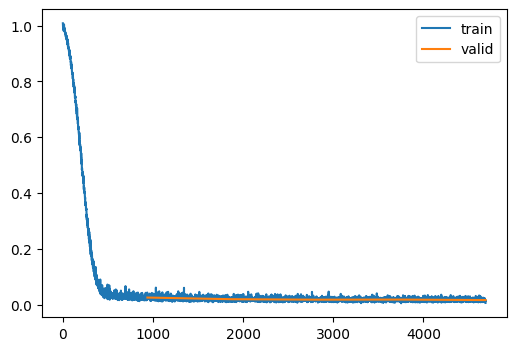

In [ ]:
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "17_ddpm_v2.pkl")

## Inference

In [ ]:
model_path = Path("models")
learn.model = torch.load(model_path / "17_ddpm_v2.pkl")

In [ ]:
set_seed(1103, False)
samples = ddpm.sample(learn.model, (16, 1, 32, 32))

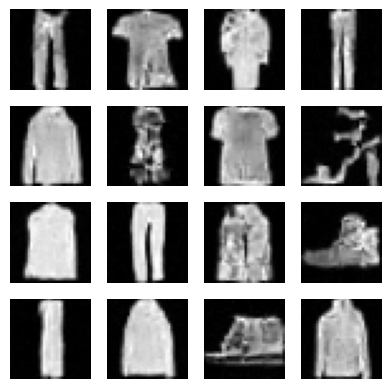

In [ ]:
show_images(samples[-1], imsize=1.2)

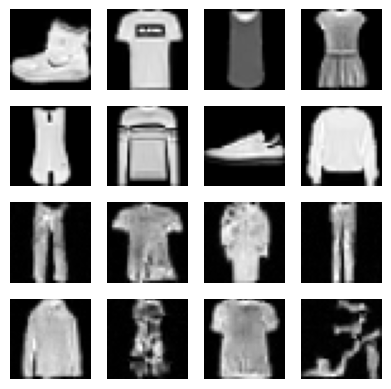

In [ ]:
show_images([*xb[:8], *samples[-1][:8]], imsize=1.2)

In [ ]:
xb[0].min(), xb[0].mean(), xb[0].max()

(tensor(0.), tensor(0.3806), tensor(0.9522))

In [ ]:
samples[-1][-1].min(), samples[-1][-1].mean(), samples[-1][-1].max()

(tensor(0.), tensor(0.3707), tensor(0.9181))

In [ ]:
xb.min(), xb.mean(), xb.max()

(tensor(0.), tensor(0.2872), tensor(0.9997))

In [ ]:
samples[-1].min(), samples[-1].mean(), samples[-1].max()

(tensor(0.), tensor(0.2857), tensor(0.9998))

In [ ]:
samples[-1][0, 0, 15:17,15:17]

tensor([[0.1052, 0.0068],
        [0.0772, 0.0070]])

In [ ]:
samples[-1][0, 0, :2,:2]

tensor([[0.0091, 0.0000],
        [0.0103, 0.0039]])

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(4,4))
frames = [0, 10, 200, 600] + list(range(800, 990, 10)) + list(range(990, 1000)) + [999] * 14

def _show(i):
    show_image(samples[frames[i]][-1], ax=ax)
animation = FuncAnimation(fig, _show, frames=len(frames))

display(HTML(animation.to_html5_video()))
plt.close()